### Prepare Workspace

In [46]:
# Import system libraries
import os
import sys

# Import data cleaning libraries
import pandas as pd
import numpy as np
import calendar
from datetime import datetime

# Import machine learning libraries
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import KFold, GridSearchCV
import shap

# Import data visualisation libraries
import matplotlib.pyplot as plt 

# Import warning libraries
import warnings
warnings.filterwarnings("ignore")

# Set working directory
os.chdir('T:\crop-yield-estimate') ##Set this to your own path
sys.path.insert(0, 'T:\crop-yield-estimate\pipeline') ##Set this to your own path

# Import preprocessing libraries
from preprocessing import cleaning
from preprocessing import feature_engineering
from preprocessing import scaling
from preprocessing import feature_selection
from preprocessing import dim_reduction

# Preprocess data
train_path = "data/Train.csv"
test_path = "data/Test.csv"
df = cleaning.clean_data(train_path, test_path)
df = feature_engineering.get_features(df)
df = scaling.scale_features(df)
df = feature_selection.select_features(df)
df = dim_reduction.reduce_dim(df)

# Split data into training and test sets
df_train = df[df['Yield'].isna() == False]
df_test = df[df['Yield'].isna() == True]

In [47]:

print(shap.__version__)


0.43.0


### Build Yield Generic Yield Per Acre Model

In [48]:
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]

df_train[outcome_cols]

,Yield,Yield_per_Acre,New_Yield,New_Yield_per_Acre
0,600.0,1920.000000,600.0,1920.000000
1,600.0,1920.000000,600.0,1920.000000
2,225.0,1518.750000,225.0,1518.750000
3,468.0,2106.000000,468.0,2106.000000
4,550.0,1173.333333,550.0,1173.333333
5,205.0,1503.333333,205.0,1503.333333
6,270.0,1980.000000,270.0,1980.000000
7,490.0,1960.000000,490.0,1960.000000
8,425.0,1870.000000,425.0,1870.000000
9,300.0,1920.000000,300.0,1920.000000


Root Mean Squared Error: 133.41314305148762


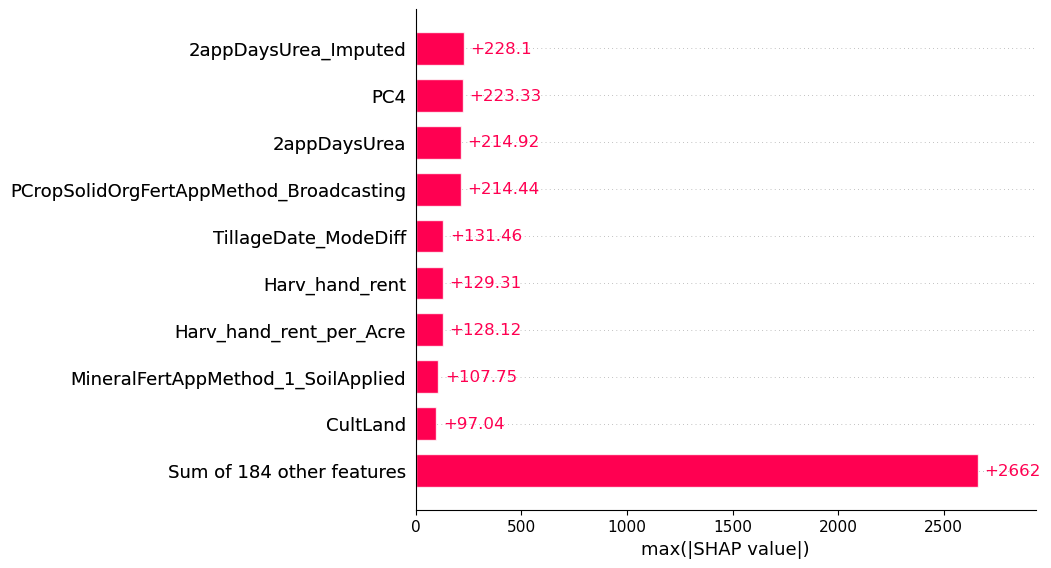

In [49]:

# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                          learning_rate = 0.1, max_depth = 5, alpha = 10,
                          n_estimators = 10)

# Train the XGBoost model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          y_pred * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)


# Create a TreeExplainer object with the XGBoost model
explainer = shap.TreeExplainer(xg_reg)

# Calculate Shapley values for a specific sample (replace index with your desired sample index)
sample_index = 21
shap_values = explainer.shap_values(X_test)

# Summary plot of Shapleys values
shap.plots.bar(explainer(X_test).abs.max(0))


In [50]:
X_train.shape[1] == shap_values.shape[1]

True

In [51]:
# How can I mimic the plot above?

top_columns = []

# Calculate the maximum absolute value of each column in the shap_values matrix
column_max_abs = np.max(np.abs(shap_values), axis=0)

# Attach maximum absolute values to column names
column_max_with_names_abs = {column: max_val for column, max_val in zip(df_train.columns, column_max_abs)}

# Sort the column maximum absolute values in descending order
sorted_column_max_abs = sorted(column_max_with_names_abs.items(), key=lambda x: x[1], reverse=True)

# Optionally, to mimic the plot, display only the top N features
N = 20  # for example, top 10 features
top_features_max = sorted_column_max_abs[:N]
other_features_sum_max = sum(value for _, value in sorted_column_max_abs[N:])

# Display top N column names with their maximum absolute values in descending order
for column, max_val in top_features_max:
    top_columns.append(column)
    print(f"{column}: {max_val}")

# And display the sum of the other features
print(f"Sum of other {len(sorted_column_max_abs) - N} features: {other_features_sum_max}")


1appDaysUrea_Imputed: 228.0968017578125
Acre_Scaled: 223.3330841064453
2appDaysUrea: 214.91629028320312
TpIrrigationPowerSource_Imputed_Diesel: 214.44253540039062
Days_bw_Till_Harv: 131.45648193359375
Harv_hand_rent: 129.30792236328125
1tdUrea_per_Acre: 128.12098693847656
PCropSolidOrgFertAppMethod_Broadcasting: 107.74761962890625
CultLand: 97.03620910644531
TransplantingIrrigationPowerSource_Diesel: 95.00704956054688
HarvestMonth_December: 82.21480560302734
PC4: 76.94606018066406
SeedlingsPerPit_Imputed: 73.25772857666016
TransIrriCost_per_Acre: 72.81318664550781
Days_bw_Nurs_SowTransp_ModeDiff_Imputed: 71.15066528320312
TpIrrigationCost_Imputed_per_Acre: 70.02641296386719
Days_bw_Harv_Thresh: 67.40693664550781
TpIrrigationCost_Imputed_per_Acre_capped: 64.80325317382812
Num_TransDetFactor: 64.0953369140625
Ganaura: 63.9644889831543
Sum of other 173 features: 1860.3175702095032


In [52]:
top_columns

['1appDaysUrea_Imputed',
 'Acre_Scaled',
 '2appDaysUrea',
 'TpIrrigationPowerSource_Imputed_Diesel',
 'Days_bw_Till_Harv',
 'Harv_hand_rent',
 '1tdUrea_per_Acre',
 'PCropSolidOrgFertAppMethod_Broadcasting',
 'CultLand',
 'TransplantingIrrigationPowerSource_Diesel',
 'HarvestMonth_December',
 'PC4',
 'SeedlingsPerPit_Imputed',
 'TransIrriCost_per_Acre',
 'Days_bw_Nurs_SowTransp_ModeDiff_Imputed',
 'TpIrrigationCost_Imputed_per_Acre',
 'Days_bw_Harv_Thresh',
 'TpIrrigationCost_Imputed_per_Acre_capped',
 'Num_TransDetFactor',
 'Ganaura']

In [53]:

# Split data
outcome_cols = ["Yield","Yield_per_Acre","New_Yield","New_Yield_per_Acre"]

# Drop columns excluding the top features
X, y = df_train.drop(outcome_cols, axis=1), df_train["New_Yield_per_Acre"]

# Drop columns that are not the top columns
X, y = X[top_columns], y

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Instantiate an XGBoost regressor model
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3,
                          learning_rate = 0.1, max_depth = 5, alpha = 10,
                          n_estimators = 10)

# Train the XGBoost model
xg_reg.fit(X_train, y_train)

# Predict on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model using RMSE (Root Mean Squared Error)
indices = list(y_test.index)
rmse = mean_squared_error(df_train.loc[indices]["New_Yield"],
                          y_pred * df_train.loc[indices]["Acre"], squared=False)
print("Root Mean Squared Error:", rmse)

Root Mean Squared Error: 138.5073078674958


In [54]:
# Calculate mean of each column in the shap_values matrix
column_means = np.mean(shap_values, axis=0)

# Attach mean values to column names
column_means_with_names = {column: mean for column, mean in zip(df_train.columns, column_means)}

# Sort the column means in descending order
sorted_column_means = sorted(column_means_with_names.items(), key=lambda x: x[1], reverse=True)

# Display column names with their mean values in descending order
for column, mean in sorted_column_means:
    print(f"{column}: {mean}")

1tdUrea_per_Acre: 3.1838040351867676
Days_bw_Harv_Thresh: 2.673140287399292
Residue_length: 1.8449985980987549
Harv_hand_rent: 1.4908565282821655
PCropSolidOrgFertAppMethod_Broadcasting: 1.4254188537597656
NursingDate_ModeDiff: 1.342139482498169
NursingMonth_June: 1.2531126737594604
Ganaura: 1.2220152616500854
HarvestMonth_December: 1.0751935243606567
Num_TransDetFactor: 1.057478666305542
TpIrrigationPowerSource_Imputed_Diesel: 0.9108383059501648
TillageDate_ModeDiff: 0.8509241342544556
ThreshingMonth_January: 0.7801411151885986
Days_bw_SowTransp_Harv: 0.732397198677063
New_Yield_per_Acre: 0.6771225333213806
2appDaysUrea_Imputed: 0.6246150732040405
TpIrrigationCost_Imputed_per_Acre: 0.5628004670143127
Days_bw_Nurs_Till_ModeDiff_Imputed: 0.5603851675987244
SeedlingsPerPit_Imputed: 0.5507445931434631
1appDaysUrea_NaN_True: 0.4919688403606415
PC6: 0.47430142760276794
Harv_method_machine: 0.4716486930847168
CultLand: 0.4476757049560547
1appDaysUrea: 0.39101001620292664
TpIrrigationSource_I

### Make Predictions

In [55]:
# # Retrain model on entire training data
# xg_reg.fit(X, y)
# print("---Training complete---")

In [56]:
# # Make predictions
# test_predictors = df_test.drop(outcome_cols, axis=1)
# test_pred = xg_reg.predict(test_predictors) * df_test["Acre"]

# # Add predictions to sample submission file
# df_test_pred = pd.read_csv("data/SampleSubmission.csv")
# df_test_pred['Yield'] = test_pred
# df_test_pred['Yield'] = np.where(df_test_pred['ID'] == 'ID_PMSOXFT4FYDW',
#                                  df_test_pred['Yield'] * 10, df_test_pred['Yield'])

# # Export submission
# df_test_pred.to_csv('submission/Submission.csv', index=False)

# print("---Predictions made---")